## BBH Dynamic recovery: curriculum learning applied to an continuous inverse PINN problem
This notebook recovers the dynamics of an Extreme-Mass-Ratio (EMR) Binary Black Hole system in the Schwarzschild metric. It is done by solving an inverse problem using the waveform produced by the system. It is solved a continuous inverse form since we solve the ODE problem for each iteration of the training loop and accumulate losses for the whole ODE solution.

Data is generated synthetically. Despite the code is prepared to run batches, this notebook only trains one system.

## Dataset Generation
We generate ground-truth orbits and waveforms by integrating the Schwarzschild equations of motion with a fixed-step RK2 solver, then compute the quadrupole waveform.


In [1]:
import torch
import math

import sys
import os

# Get the absolute path to the target directory
notebook_dir = os.path.dirname(os.path.abspath("run_kerr.ipynb"))
target_path = os.path.join(notebook_dir, "..", "experiments", "binary_black_holes_emr_inverse_problem")
sys.path.insert(0, os.path.abspath(target_path))

from dataset import KerrDataset, generate_mesh
from numerical_solvers import solve_ode_rk2
from orbital_mechanics import compute_waveform, compute_orbit


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set seeds for reproducibility
seed = 1234
torch.manual_seed(seed)

# Dataset
chi0 = math.pi/2
phi0 = 0.0
M = 1.0
e = 0.5
p = 50

dt = 20
tspan = torch.tensor([0, 60e3])
print(f"dataset size: {int(tspan[1] / dt)}")
train_mesh = generate_mesh(tspan, dt, factor=1)


train_dataset = KerrDataset(
    phi0=phi0,
    chi0=chi0,
    p=p,
    M=M,
    e=e,
    a_space=[0.25],
    train_mesh=train_mesh
)

# val_dataset = KerrDataset(
#     phi0=phi0,
#     chi0=chi0,
#     p=p,
#     M=M,
#     e=e,
#     a_space=[0.5],
#     train_mesh=train_mesh
# )

dataset size: 3000
Generated training data for system: p: 50.0, a: 0.25, e: 0.5, M: 1.0


Plot an item of the dataset

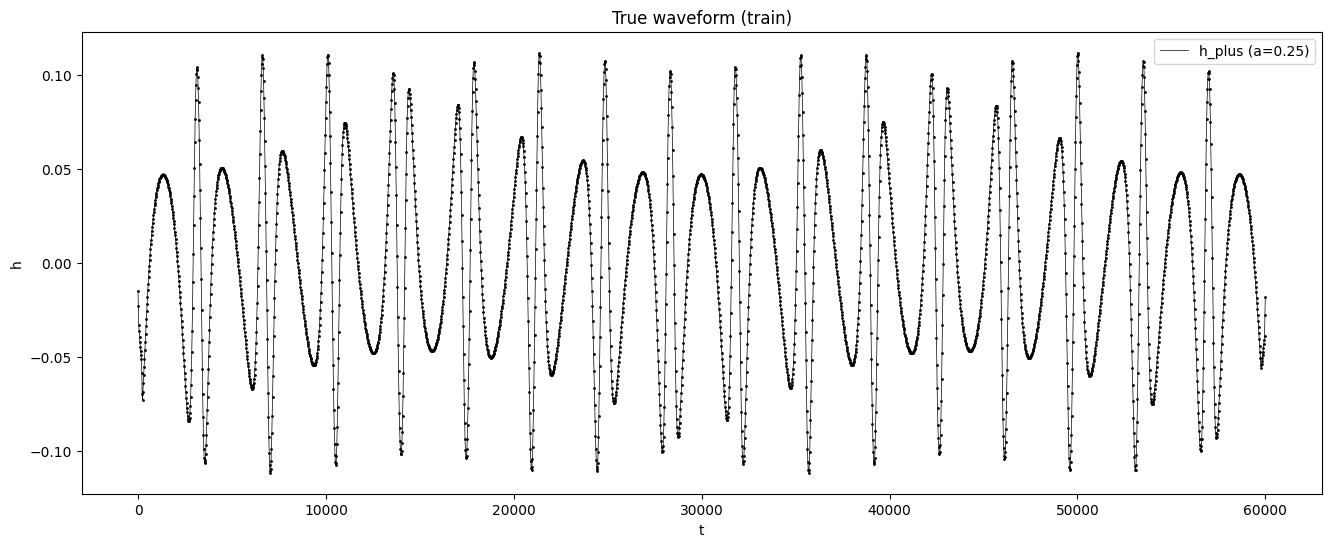

In [2]:
import matplotlib.pyplot as plt

def plot_waveform(waveform_info, ax=None, label="h_plus", color='k', title=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(16,6))
    t = waveform_info["tsteps"].detach().cpu().numpy()
    h = waveform_info["waveform"].detach().cpu().numpy()

    label = f"{label} (a={waveform_info['a'][0]:.2f})"
    ax.plot(t, h, '.', markersize=2, color=color)
    ax.plot(t, h, '-', label=label, linewidth=0.5, color=color)
    ax.set_xlabel("t")
    ax.set_ylabel("h")
    if title:
        ax.set_title(title)
    ax.legend()
    return ax

ax = plot_waveform(train_dataset[0], title="True waveform (train)")
# ax = plot_waveform(train_dataset[1], ax=ax, title="True waveform (train)",  color='g')
# ax = plot_waveform(train_dataset[2], ax=ax, title="True waveform (train)", color='orange')
# ax = plot_waveform(train_dataset[3], ax=ax, title="True waveform (train)", color='r')
plt.show();

## Model Definition
We define a small neural network that outputs multiplicative corrections to the base model of the PINN. The model is used inside an ODE solver to generate predicted trajectories and waveforms.


In [3]:
from kerr_models import NNOrbitModel_Kerr_EMR, BasicNN

model = BasicNN()
model.to(device).double()

# frame the ODE problem for a single batch and will be updated during training
batch = train_dataset[0]
batch = {k: v.unsqueeze(0).to(device) for k, v in batch.items()} # add batch dim and move to device
ode_problem = NNOrbitModel_Kerr_EMR(
    p=batch['p'],
    M=batch['M'],
    e=batch['e'],
    a=batch['a'],
    network=model
)

In [4]:
model

BasicNN(
  (model): Sequential(
    (0): LambdaLayer()
    (1): Linear(in_features=2, out_features=64, bias=True)
    (2): Cosine()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

Let's plot the solution before start training.

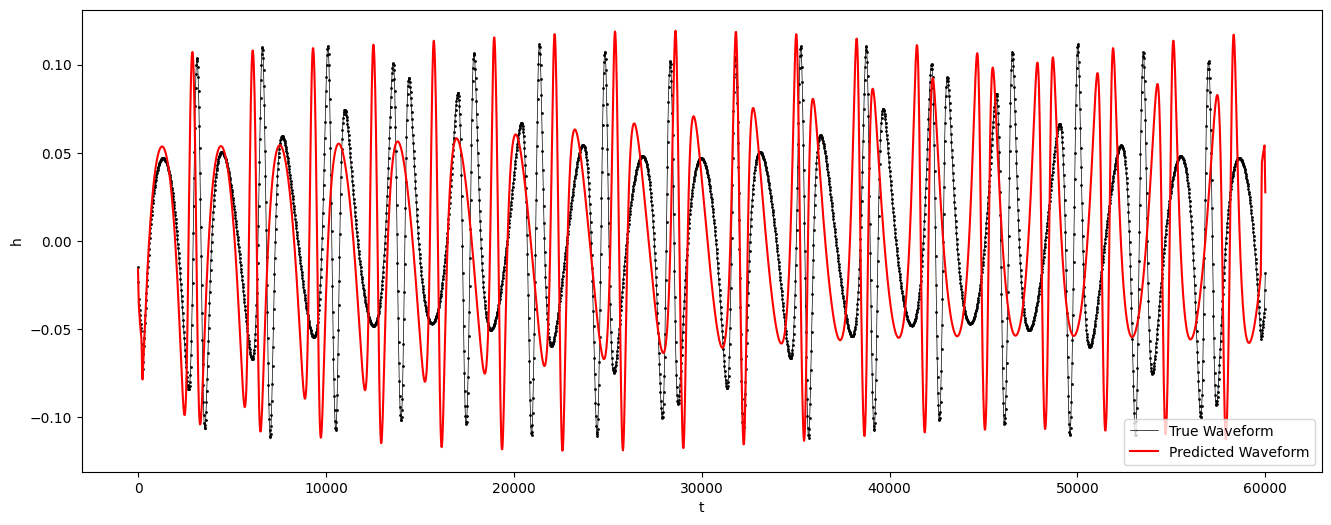

In [5]:
#test the ODE solver and waveform computation for a single batch
system_solution = solve_ode_rk2(
    ode_problem=ode_problem,
    system_params=batch
)
orbit = compute_orbit(system_solution, system_params=batch)
pred_waveform = compute_waveform(orbit, system_params=batch)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,6))
t = batch["tsteps"][0].detach().cpu().numpy()
h = batch["waveform"][0].detach().cpu().numpy()
h_pred = pred_waveform[0].detach().cpu().numpy()
ax.plot(t, h, '.', markersize=2, color='k')
ax.plot(t, h, '-', label="True Waveform", linewidth=0.5, color='k')
ax.plot(t, h_pred, '-', markersize=2, color='r', label="Predicted Waveform")
ax.set_xlabel("t")
ax.set_ylabel("h")
plt.legend()
plt.show();

## Training
We optimize the neural ODE parameters to minimize an L1 loss between predicted and true waveforms.
Notes:
- Training uses RK2 in the ODE solve to match evaluation.
- Smoothing is disabled during training for sharper gradients.
- LBFGS optimizer with linear search is enabled instead of Adam for faster convergence.
- We evaluate loss function on a trimmed version of the waveform to avoid numerical issues of solving the ODE.
- Curriculum learning: start with a shorter time window (smaller `tspan` or a cropped `tsteps`) for a few epochs, then gradually extend to the full window. This stabilizes LBFGS and improves early convergence.


In [6]:
def crop_batch(batch, t_max):
    """
    Crop all time-dependent tensors in the batch to the last time step <= t_max. to enable curriculum learning during training.
    """
    t = batch["tsteps"]
    mask = t <= t_max
    idx = torch.where(mask[0])[0]
    last = idx[-1].item() + 1

    # slice all time-dependent tensors
    out = dict(batch)
    out["tsteps"] = out["tsteps"][:, :last]
    out["solution"] = out["solution"][:, :, :last]
    out["waveform"] = out["waveform"][:, :last]
    return out

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import tqdm.notebook as tdqm


seed = 1234
torch.manual_seed(seed)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 20
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=100, line_search_fn="strong_wolfe")

model.train()

curriculum = [
    (3, 10000),   # first 5 epochs use t<=10000
    (3, 20000),   # next 5 epochs use t<=20000
    (3, 50000),  # rest full window
]
num_epochs = sum(n for n, _ in curriculum)
num_iterations = num_epochs * len(train_loader)
progress_bar = tdqm.tqdm(total=num_iterations, desc="Training")

train_loss = []
trim_window = 50
iterations = 0
epoch_counter = 0

for n_epochs, t_max in curriculum:
    for _ in range(n_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            batch = crop_batch(batch, t_max)

            def closure():
                optimizer.zero_grad()
                ode_problem.update_params(p=batch['p'], M=batch['M'], e=batch['e'])
                system_solution = solve_ode_rk2(ode_problem=ode_problem, system_params=batch)
                pred_orbit = compute_orbit(system_solution, system_params=batch)
                pred_waveform = compute_waveform(pred_orbit, system_params=batch, smooth_window=1)

                y_true = batch["waveform"]
                pred_waveform = pred_waveform[:, trim_window:-trim_window]
                y_true = y_true[:, trim_window:-trim_window]
                loss = F.l1_loss(pred_waveform, y_true)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            train_loss.append(loss.item() / batch_size)
            epoch_loss += loss.item()
            progress_bar.update(1)
            iterations += 1
            print(f"Iteration {iterations}: loss={loss.item():.6f}")

        epoch_counter += 1


Training:   0%|          | 0/9 [00:00<?, ?it/s]

## Evaluation
After training, we solve the ODE and compare the predicted waveform to the true waveform. It almost perfectly matches visually.


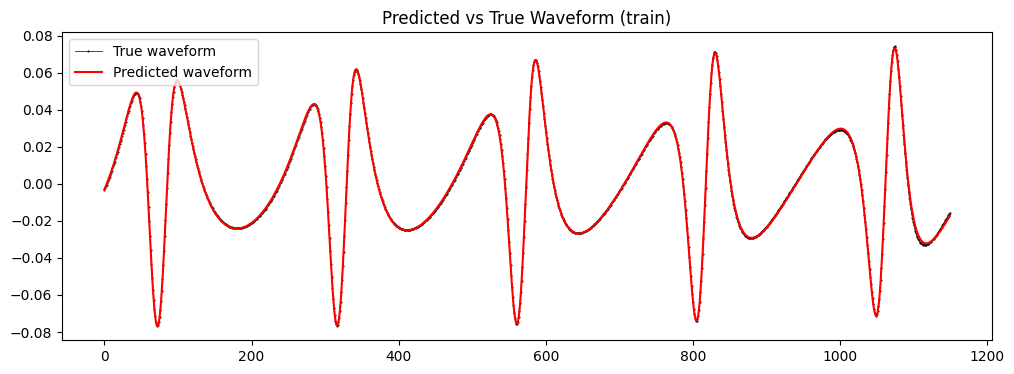

In [23]:
# frame the ODE problem for the current batch
ode_problem = NNOrbitModel_Schwarzcshild_EMR(
    p=batch['p'],
    M=batch['M'],
    e=batch['e'],
    network=model
)
# Predict orbit (chi, phi) for each t
system_solution = solve_ode_rk2(
    ode_problem=ode_problem,
    system_params=batch
)
pred_orbit = compute_orbit(system_solution, system_params=batch)
# compute true waveform for the current batch
pred_waveform = compute_waveform(pred_orbit, system_params=batch)

plt.figure(figsize=(12,4))
plt.title("Predicted vs True Waveform (train)")
plt.plot(batch['waveform'][0].detach().cpu().numpy()[trim_window:-trim_window], '.-', markersize=1, linewidth=0.5, label="True waveform", color='k');
plt.plot(pred_waveform[0].detach().cpu().numpy()[trim_window:-trim_window], label="Predicted waveform", color='r');
plt.legend()
plt.show()

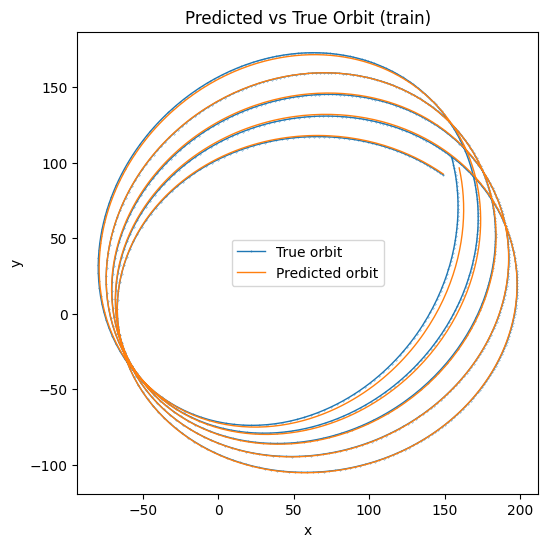

In [22]:

def plot_phase_space(batch, pred_orbit, title=None):
    """
    Plot phase space trajectory as (phi, chi).
    Expects batch dict with keys 'solution' (2,T) and optional 'tsteps'.
    """
    _, ax = plt.subplots(figsize=(6,6))

    orbit = batch["orbit"][0].detach().cpu().numpy()[:, trim_window:-trim_window]
    pred_orbit = pred_orbit[0].detach().cpu().numpy()[:, trim_window:-trim_window]

    ax.plot(orbit[0], orbit[1], '.-', linewidth=1.0, markersize=0.5, label="True orbit")
    ax.plot(pred_orbit[0], pred_orbit[1], '-', linewidth=1.0, label="Predicted orbit")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    if title:
        ax.set_title(title)
    ax.legend()
    plt.show()

plot_phase_space(batch, pred_orbit, title="Predicted vs True Orbit (train)")